In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,classification_report
import seaborn as sns

In [2]:
# Function to load images using PIL
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    labels = []
    for class_label, class_name in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                if os.path.isfile(img_path):
                    img = Image.open(img_path).convert('RGB')  # Convert to RGB if the image is in grayscale
                    #img = img.resize(target_size)  # Resize the image to the specified target size
                    img_array = np.array(img) / 255.0  # Normalize pixel values to be between 0 and 1
                    images.append(img_array)
                    labels.append(class_label)
    return np.array(images), np.array(labels)

# Now you have the images and labels, and you can use them as needed for your model

In [3]:
# Load images using the function
training_path = 'PandasBears/train'
testing_path = 'PandasBears/test'
x_train, y_train = load_images_from_folder(training_path)
x_test, y_test = load_images_from_folder(testing_path)

In [4]:
# Shuffle the dataset
indices_train = np.arange(len(x_train))
np.random.shuffle(indices_train)
x_train = x_train[indices_train]
y_train = y_train[indices_train]

indices_test = np.arange(len(x_test))
np.random.shuffle(indices_test)
x_test = x_test[indices_test]
y_test = y_test[indices_test]

In [5]:
from sklearn.preprocessing import OneHotEncoder
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.fit_transform(y_test)

In [6]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(500, 256, 256, 3) (500, 1)
(100, 256, 256, 3) (100, 1)


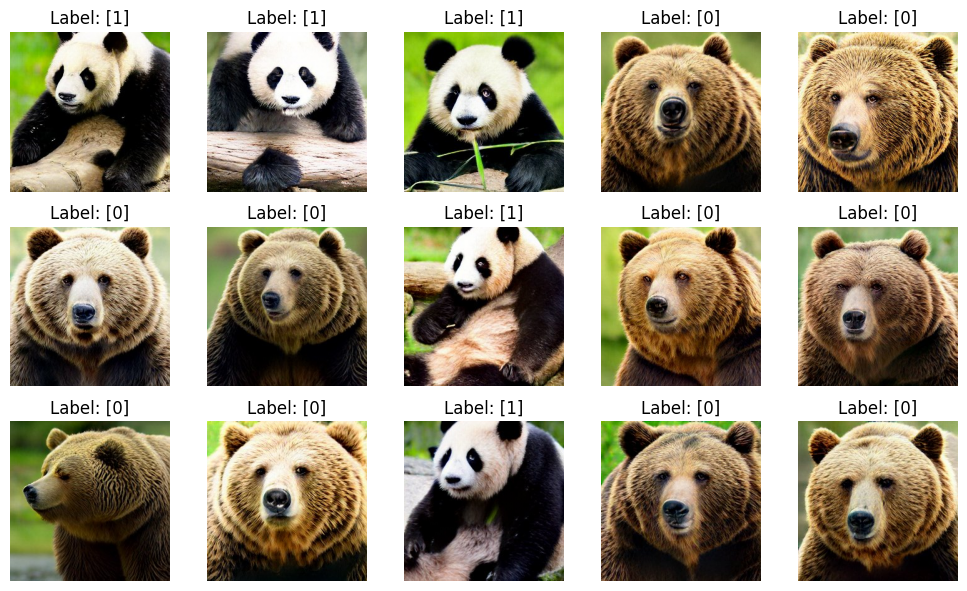

In [7]:
# Visualize sample images from the dataset
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()
for i in range(15):
    axes[i].imshow(x_train[i].reshape(256, 256,3), cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [13]:
model = Sequential()

model.add(Conv2D(80, (3, 3), activation='relu', input_shape=(256, 256, 3)))  # 8 filters of size 3x3, ReLU activation function
model.add(MaxPooling2D((2, 2)))  # Max pooling with pool size 2x2

model.add(Conv2D(60, (3, 3), activation='relu'))  # 16 filters of size 3x3, ReLU activation
model.add(MaxPooling2D((2, 2)))  # Max pooling

model.add(Flatten())  # Flatten the output from 2D to 1D

model.add(Dense(10, activation='relu'))  # Fully connected layer with 30 units, ReLU activation

model.add(Dense(2, activation='softmax'))  # Output layer with 1 units (classes), softmax activation

In [14]:
model.summary() # print the archticture of model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 80)      2240      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 80)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 60)      43260     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 60)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 230640)            0         
                                                                 
 dense_2 (Dense)             (None, 10)               

In [15]:
# print trainable parameters of model
for i in model.layers:
    print(f"Layer {i.name} : {i.count_params()} trainable parameters")
    print('----------------------------------------------')

Layer conv2d_2 : 2240 trainable parameters
----------------------------------------------
Layer max_pooling2d_2 : 0 trainable parameters
----------------------------------------------
Layer conv2d_3 : 43260 trainable parameters
----------------------------------------------
Layer max_pooling2d_3 : 0 trainable parameters
----------------------------------------------
Layer flatten_1 : 0 trainable parameters
----------------------------------------------
Layer dense_2 : 2306410 trainable parameters
----------------------------------------------
Layer dense_3 : 22 trainable parameters
----------------------------------------------


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
model.fit(x_train, y_train_encoded, batch_size=64, epochs=5)

Epoch 1/5
8/8 [==============================] - 40s 5s/step - loss: 0.7893 - accuracy: 0.6280
Epoch 2/5
8/8 [==============================] - 39s 5s/step - loss: 0.5281 - accuracy: 0.7900
Epoch 3/5
8/8 [==============================] - 39s 5s/step - loss: 0.3733 - accuracy: 0.9660
Epoch 4/5
8/8 [==============================] - 39s 5s/step - loss: 0.3581 - accuracy: 0.9900
Epoch 5/5
8/8 [==============================] - 39s 5s/step - loss: 0.3469 - accuracy: 0.9960


In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

4/4 [==============================] - 2s 430ms/step - loss: 0.3391 - accuracy: 1.0000
Test Loss: 0.3391
Test Accuracy: 1.0000


In [19]:
y_pred = model.predict(x_test)

4/4 [==============================] - 2s 392ms/step


In [20]:
print(y_pred.shape,y_test.shape)

(100, 2) (100, 1)


In [21]:
# convert from One Hot Encoding to int values that represent int labels
num_of_classes = y_test_encoded.shape[1]
print('Number of classes : ' , num_of_classes)
true_labels = []
for label in y_test_encoded:
    true_label = np.argmax(label)
    true_labels.append(true_label)
print(true_labels[:30])

pred_labels = []
for label in y_pred:
    true_label = np.argmax(label)
    pred_labels.append(true_label)
#print(set(true_labels))
print(pred_labels[:30])

Number of classes :  2
[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [22]:
set(pred_labels)

{0, 1}

In [23]:
precision = precision_score (true_labels,pred_labels , average='macro')
recall = recall_score(true_labels,pred_labels , average='macro')
f1 = f1_score(true_labels,pred_labels,average='macro')

print('precision_score : ' , precision )
print('recall_score : ' , recall )
print('f1_score : ' , f1 )

precision_score :  1.0
recall_score :  1.0
f1_score :  1.0


[[50  0]
 [ 0 50]]


<AxesSubplot: >

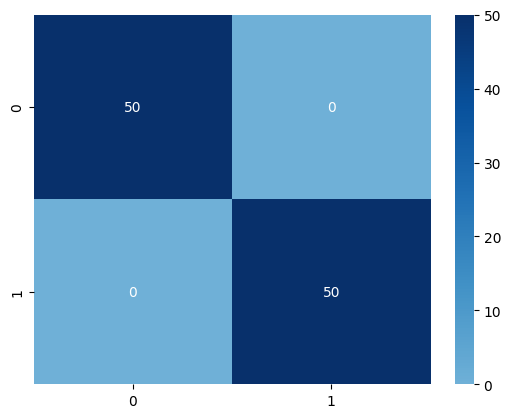

In [24]:
cm = confusion_matrix(true_labels,pred_labels)
print(cm)

sns.heatmap(cm,center=True,cmap='Blues' ,annot = True)

In [25]:
repo = classification_report(true_labels,pred_labels)
print(repo)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

